In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib import cm
import lin_solv as solv

In [2]:
def encode(i,j,Ny):
    return int(i*Ny+j)

def i_encode(a,Ny):
    return a//Ny, a%Ny

In [3]:
def Poisson_2D(cmin,cmax,Nx,Ny,method='jacobi'):
    
    def real2grid(x,y,cmin,cmax,Nx,Ny):
        gp = np.zeros(2)
        if x < cmin[0] or x > cmax[0] or y < cmin[1] or y > cmax[1]:
            raise Exception(f'real2grid point {p} outside the box')
        else:
            delta = np.zeros(2)
            delta[0] = (cmax[0]-cmin[0])/Nx
            delta[1] = (cmax[1]-cmin[1])/Ny
            gp[0] = int((x-cmin[0])/delta[0])
            gp[1] = int((y-cmin[1])/delta[1])
            
        return gp[0], gp[1]
    
    def grid2real(i,j,cmin,d):
        return cmin[0]+(i+0.5)*d[0], cmin[1]+(j+0.5)*d[1]
    
    def constant_bc(cmin,cmax,Nx,Ny):
        alpha = encode(0,0,Ny)
        V0 = 0.0
        V1 = 5e-4
        bc = {alpha:V0}
        
        for i in range(Nx):
            alpha = encode(i,0,Ny)
            bc.update({alpha:V0})
            alpha = encode(i,Ny-1,Ny)
            bc.update({alpha:V0})
            
        for j in range(Ny):
            alpha = encode(0,j,Ny)
            bc.update({alpha:V0})
            alpha = encode(Nx-1,j,Ny)
            bc.update({alpha:V0})
            
        bc = dict(sorted(bc.items()))
        return bc
    def rhs(cmin,cmax,Nx,Ny,val):
        N = Nx*Ny
        b = np.zeros(N)
        deltax=(cmax[0]-cmin[0])/Nx
    
        # circular ring of charge with radius of 0.5
        r = 0.5
        m = 2*r*np.pi/deltax
        n = np.sqrt(2*deltax*deltax)
        theta = deltax/r
        
        for angle in np.arange(0,2*np.pi,theta):
            x = r*np.cos(angle)
            y = r*np.sin(angle)
            i,j = real2grid(x,y,cmin,cmax,Nx,Ny)
            alpha = encode(i,j,Ny)
            b[alpha]=val
        return b
    
    epsilon_0 = 8.845e-12 #Farad/m
    chi = 1e-9 #Scaling for space in nm
    C = 1.6e-19 #electronic charge in C
    phi_0 = C/(epsilon_0*chi) #Volt
    
    
    rho = -1.6e8 #Charge density of 1 e/nm^3 in C/m^3
    rho_p = rho*chi*chi*chi/C
    
    D = np.zeros(2)
    D[0] = (cmax[0]-cmin[0])/Nx
    D[1] = (cmax[1]-cmin[1])/Ny
    
    N=Nx*Ny
    
    A = np.zeros((N,N))
    b = rhs(cmin,cmax,Nx,Ny,rho_p)
    
    bc = constant_bc(cmin,cmax,Nx,Ny)
    
    for i in range(Nx):
        for j in range(Ny):
            alpha = encode(i,j,Ny)
            aa = encode(i+1,j,Ny)
            bb = encode(i-1,j,Ny)
            cc = encode(i,j+1,Ny)
            dd = encode(i,j-1,Ny)
            
            A[alpha][alpha] = -2/(D[0]*D[0]) - 2/(D[1]*D[1])
            
            try:
                A[alpha][aa] = 1/(D[0]*D[0])
            except Exception as e:
                pass
            
            if bb >= 0:
                A[alpha][bb] = 1/(D[0]*D[0])
                
            try:
                A[alpha][cc] = 1/(D[1]*D[1])
                
            except Exception as e:
                pass
            
            if dd >= 0:
                A[alpha][dd] = 1/(D[1]*D[1])
                
    if method == 'jacobi':
        begin_time = time.time()
        y = solv.jacobi(A,b,fixed=bc)
        end_time=time.time()
        compute_time = (end_time-begin_time)*1000
        
    elif method == 'gaussian_elimination':
        begin_time = time.time()
        y = solv.gaussian_elimination(A,b,fixed=bc)
        end_time = time.time()
        compute_time = (end_time-begin_time)*1000
        
    X =[]
    Y=[]
    Pot=[]
    
    for alpha,pot in enumerate(y):
        i,j = i_encode(alpha,Ny)
        xx, yy = grid2real(i,j,cmin,D)
        X.append(xx)
        Y.append(yy)
        Pot.append(pot*phi_0)
        
    return X, Y, Pot, compute_time
        

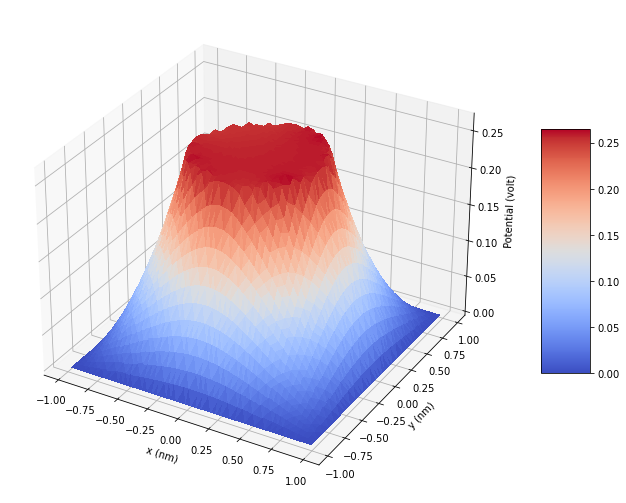

In [4]:
cmin = np.array([-1,-1])
cmax = np.array([1,1])
x,y,p,t = Poisson_2D(cmin,cmax,50,50)
fig = plt.figure(figsize = (16,9))
ax = plt.axes(projection='3d')
surface = ax.plot_trisurf(x,y,p,cmap=cm.coolwarm,linewidth=0,antialiased=False)

ax.set_xlabel('x (nm)')
ax.set_ylabel('y (nm)')
ax.set_zlabel('Potential (volt)')
fig.colorbar(surface,shrink = 0.5,aspect = 5)
plt.show()

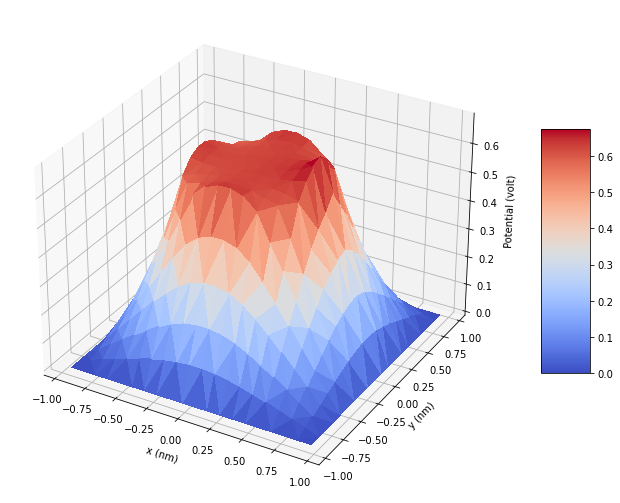

In [5]:
# changed gridpoints to 20 to see difference
cmin = np.array([-1,-1])
cmax = np.array([1,1])
x,y,p,t = Poisson_2D(cmin,cmax,20,20)
fig = plt.figure(figsize = (16,9))
ax = plt.axes(projection='3d')
surface = ax.plot_trisurf(x,y,p,cmap=cm.coolwarm,linewidth=0,antialiased=False)

ax.set_xlabel('x (nm)')
ax.set_ylabel('y (nm)')
ax.set_zlabel('Potential (volt)')
fig.colorbar(surface,shrink = 0.5,aspect = 5)
plt.show()

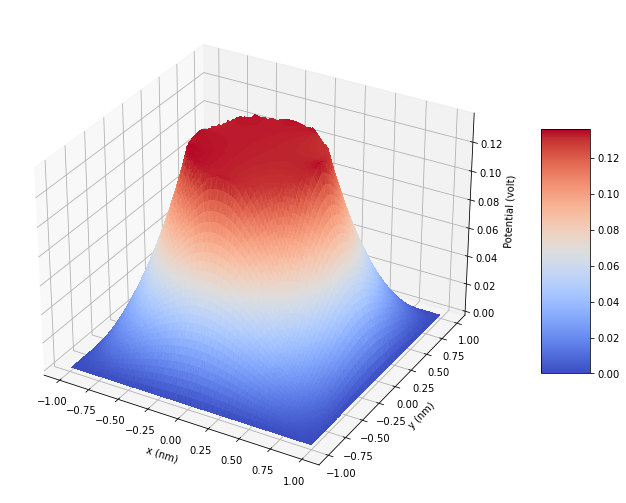

In [6]:
# changed gridpoints to 100 to see difference
cmin = np.array([-1,-1])
cmax = np.array([1,1])
x,y,p,t = Poisson_2D(cmin,cmax,100,100)
fig = plt.figure(figsize = (16,9))
ax = plt.axes(projection='3d')
surface = ax.plot_trisurf(x,y,p,cmap=cm.coolwarm,linewidth=0,antialiased=False)

ax.set_xlabel('x (nm)')
ax.set_ylabel('y (nm)')
ax.set_zlabel('Potential (volt)')
fig.colorbar(surface,shrink = 0.5,aspect = 5)
plt.show()

To show the stability and quality of the solution, I reduced and increased the number of gridpoints to 20 and 100 respectively and from the plots gotten above:
It is observed that when the number of gridpoints is reduced to 20, the quality and stability also reduced but the time complexity was much more faster and when the number of gridpoints is increased to 100, the quality and stability was better. However, it will drastically increase time complexity.